The first thing we need to do is import the useful libraries.

In [1]:
import os
import h5py
import argparse
import datetime
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from functions import plot_regression

Now, we need to create/define our working directories.

In [2]:
project_dir='/your/directory'
data_dir=os.path.join(project_dir,'data')
results_dir=os.path.join(project_dir,'results_cv')
string_dir='mkdir -p '+results_dir
os.system(string_dir)

0

We also need to load the dataset. In this case we have already split Reps 1, 2, and 3 for train and test. So, for now we will load only the training part of the dataset.

In [3]:
X=[]
Y=[]
for rep in range(1,4):
    #Data
    file_name_data=os.path.join(data_dir,'rep_'+str(rep),'data_train.h5')
    h5f=h5py.File(file_name_data,'r')
    x=h5f['train_dataset'][:]
    h5f.close()
    X.append(x)

    #Labels
    y=[]
    file_name_labels=os.path.join(data_dir,'rep_'+str(rep),'labels_train.txt')
    file = open(file_name_labels,"r") 
    for line in file:
        y.append(float(line.strip()))
    Y.append(y)

We can visualize some properties of our data.

In [4]:
for rep in range(1,4):
    print('Rep {} has {} samples, each containing {} dates. The size of each image is {}x{}, with {} channels.'.format(rep,
        X[rep-1].shape[0],X[rep-1].shape[1],X[rep-1].shape[2],X[rep-1].shape[3],X[rep-1].shape[4]))
    print('There are {} labels for Rep {}.'.format(len(Y[rep-1]), rep))
    print('-----------')

Rep 1 has 256 samples, each containing 12 dates. The size of each image is 200x100, with 5 channels.
There are 256 labels for Rep 1.
-----------
Rep 2 has 256 samples, each containing 12 dates. The size of each image is 200x100, with 5 channels.
There are 256 labels for Rep 2.
-----------
Rep 3 has 256 samples, each containing 12 dates. The size of each image is 200x100, with 5 channels.
There are 256 labels for Rep 3.
-----------


After we confirmed that the dimensions of the datasets for Rep 1 and Rep 2 match, we can merge them to have a unique dataset that we will use to train our DL model. Initially we will combine Reps 1 and 2, train the model and test on Rep 3. Then, we will do the same with Reps 2 and 3, and 1 and 3. This way we will have a 3-fold cross validation. The final scores will be the average of the three.

NOTE: Keep in mind that the index of the dataset/label refers to the Rep that will be used for TESTING the model.

In [5]:
# Generate the datasets for the 3-fold and labels into a dictionary

# Extract data and labels into independen lists
X_aux, Y_aux = [],[]
for i in range(3):
    X_aux.append([b for a,b in enumerate(X) if a!=i])
    Y_aux.append([b for a,b in enumerate(Y) if a!=i])

print('Shape of the new dataset:\n')
X_train_dict={}
for i in range(1, 4):
    # Transforms lists into arrays
    X_concat=np.concatenate(X_aux[i-1])
    X_train_dict['X_train_{}'.format(i)] = X_concat
    print('X_{}: {}'.format(i, X_concat.shape))
    
Y_train_dict={}
for i in range(1, 4):
    # Transforms lists into arrays
    Y_concat=np.concatenate([*Y_aux[i-1]])
    Y_train_dict["Y_train_{}".format(i)] = Y_concat
    print('Y_{}: {}'.format(i, Y_concat.shape))


data_shape=X_train_dict['X_train_1'][0].shape
print('\nThe dimension of each data sample is: ', data_shape)


Shape of the new dataset:

X_1: (512, 12, 200, 100, 5)
X_2: (512, 12, 200, 100, 5)
X_3: (512, 12, 200, 100, 5)
Y_1: (512,)
Y_2: (512,)
Y_3: (512,)

The dimension of each data sample is:  (12, 200, 100, 5)


Just in case, we check that the generated arrays are not the same.

In [6]:
compare_x_1 = X_train_dict['X_train_1']==X_train_dict['X_train_2']
compare_x_2 = X_train_dict['X_train_2']==X_train_dict['X_train_3']
compare_x_3 = X_train_dict['X_train_1']==X_train_dict['X_train_3']
print('Data arrays are equal? ',compare_x_1.all(), compare_x_2.all(), compare_x_3.all())
    
compare_y_1 = Y_train_dict['Y_train_1']==Y_train_dict['Y_train_2']
compare_y_2 = Y_train_dict['Y_train_2']==Y_train_dict['Y_train_3']
compare_y_3 = Y_train_dict['Y_train_1']==Y_train_dict['Y_train_3']
print('Label arrays are equal? ',compare_y_1.all(), compare_y_2.all(), compare_y_3.all())

Data arrays are equal?  False False False
Label arrays are equal?  False False False


The datset is ready to use. we can create the DL model.

In [7]:
def model_3DCNN(dropout=0.33,optimizer='adadelta',loss='mean_absolute_percentage_error'):
    #3D CNN as implemented for the previous work
    model=Sequential()
    model.add(Conv3D(64,kernel_size=(3,3,3),activation='relu',
                     data_format='channels_last',input_shape=data_shape,
                     padding='same'))
    model.add(Conv3D(64,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    model.add(Dropout(dropout))
    model.add(Conv3D(128,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(128,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    model.add(Dropout(dropout))
    model.add(Conv3D(256,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(256,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(256,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(MaxPooling3D(pool_size=(2,2,2),strides=(2,2,2)))
    model.add(Dropout(dropout))
    model.add(Conv3D(512,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(512,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(512,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(MaxPooling3D(pool_size=(1,2,2),strides=(2,2,2)))
    model.add(Dropout(dropout))
    model.add(Conv3D(512,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(512,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Conv3D(512,kernel_size=(3,3,3),activation='relu',
                    padding='same'))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer=optimizer,loss=loss,metrics=['mae','mse'])  
    
    return model

We can visualize the model that we will train.

In [8]:
model=model_3DCNN()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 200, 100, 64)  8704      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 200, 100, 64)  110656    
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 100, 50, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 100, 50, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 6, 100, 50, 128)   221312    
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 6, 100, 50, 128)   442496    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 50, 25, 128)    0

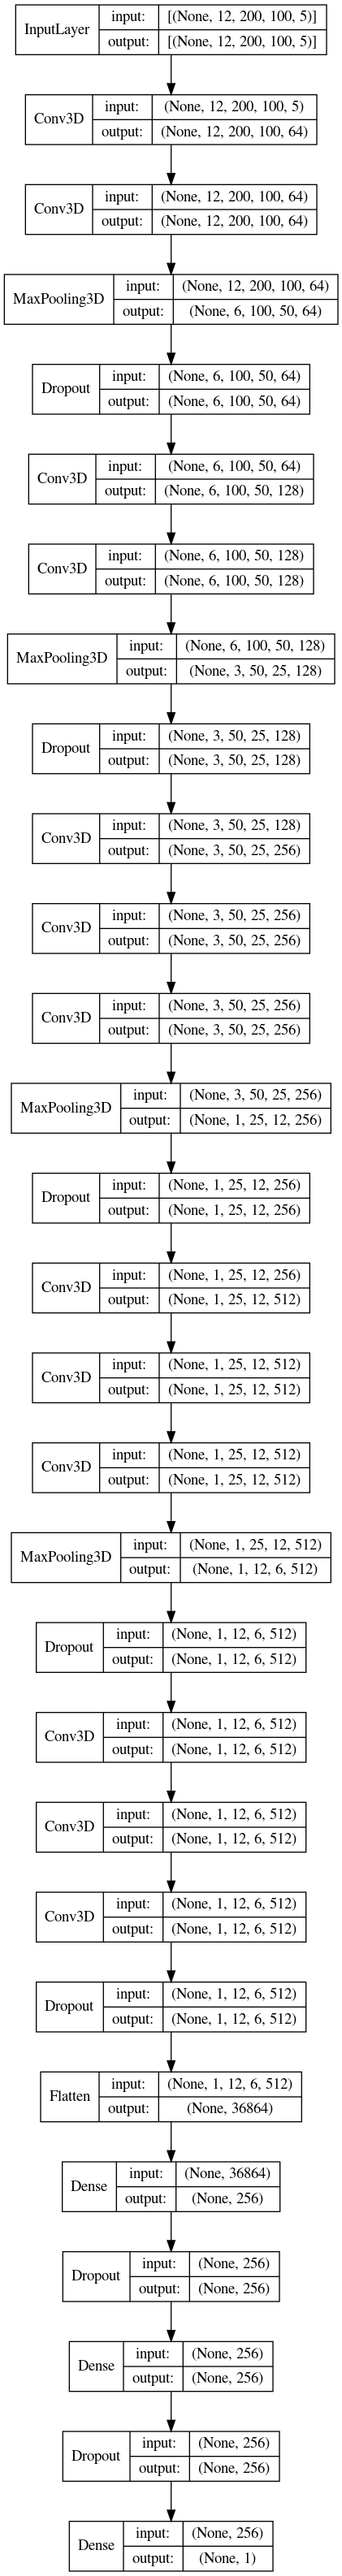

In [9]:
plot_model(model,to_file=os.path.join(results_dir,'network_model.png'),
           show_shapes=True,show_layer_names = False)

In order to find the best hyperparameters (dropout), we use a grid-search process.

In [9]:
def grid_search(model, X_train, Y_train, param_grid, epochs, batch_size, saved_model_name):
    '''
    Automates the grid search process, in order to do this for the 3 Reps.
    Takes the aurguments for the GS process and model fit.
    Returns the best estimator, useful for predictions and evaluation.
    '''
    model = KerasRegressor(build_fn=model)
    checkpointer = ModelCheckpoint(filepath=saved_model_name, save_best_only=False)
        
    # Grid search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_percentage_error',
                        cv=3, refit=True,verbose=True, error_score='raise')
    
    init_time=datetime.datetime.now()
    print('Grid search starts at: ',init_time) 
    grid_result = grid.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer],verbose=0)
    end_time=datetime.datetime.now()
    print('Grid search finishes at: ',end_time)
    
    total_time=end_time-init_time
    print('Total duration of hyperparameter search: ',total_time)
    
    # Summarize results
    print('Grid search results:\n')
    print('Best: %f using %s' % (grid_result.best_score_,grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print('\nmean_test_score (std_test_score): params')
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    print('\n\n**********\n')
    
    return grid_result.best_estimator_

In [10]:
#Hyperparameters
dropout = [0.1, 0.25, 0.33]
param_grid=dict(dropout=dropout)

epochs=1000
batch_size=8

# Calls the GS function for the 3 reps
reg_dict={}
for i in range(1,4):   
    print('Grid search ', i)
    reg=grid_search(model=model_3DCNN, X_train=X_train_dict['X_train_{}'.format(i)], Y_train=Y_train_dict['Y_train_{}'.format(i)],
                    param_grid=param_grid, epochs=epochs, batch_size=batch_size,
                    saved_model_name=os.path.join(results_dir,'model_{}.h5'.format(i)))
    reg_dict['reg_{0}'.format(i)] = reg

Grid search  1


**********

Grid search starts at:  2021-09-17 09:32:01.523255
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Grid search finishes at:  2021-09-19 10:01:18.424237
Total duration of hyperparameter search:  2 days, 0:29:16.900982
Grid search results:

Best: -0.121986 using {'dropout': 0.1}

mean_test_score (std_test_score): params
-0.121986 (0.020820) with: {'dropout': 0.1}
-0.162186 (0.021924) with: {'dropout': 0.25}
-0.187377 (0.020996) with: {'dropout': 0.33}
Grid search  2


**********

Grid search starts at:  2021-09-19 10:01:18.427809
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Grid search finishes at:  2021-09-21 09:18:08.378182
Total duration of hyperparameter search:  1 day, 23:16:49.950373
Grid search results:

Best: -0.113551 using {'dropout': 0.1}

mean_test_score (std_test_score): params
-0.113551 (0.010972) with: {'dropout': 0.1}
-0.158406 (0.014522) with: {'dropout': 0.25}
-0.192645 (0.036113) with: {'dropout': 0.33}
Grid search 

Now that we have our best possible model, we can use the test set (Reps 1, 2, and 3) to make predictions and evaluate its performance.

First, we load the test dataset.

In [11]:
X=[]
Y=[]
for rep in range(1,4):
    #Data
    file_name_data=os.path.join(data_dir,'rep_'+str(rep),'data_test.h5')
    h5f=h5py.File(file_name_data,'r')
    x=h5f['test_dataset'][:]
    h5f.close()
    X.append(x)

    #Labels
    y=[]
    file_name_labels=os.path.join(data_dir,'rep_'+str(rep),'labels_test.txt')
    file = open(file_name_labels,"r") 
    for line in file:
        y.append(float(line.strip()))
    Y.append(y)
    
    print('Rep {} has {} samples, each containing {} dates. The size of each image is {}x{}, with {} channels.'.format(rep,
        X[rep-1].shape[0],X[rep-1].shape[1],X[rep-1].shape[2],X[rep-1].shape[3],X[rep-1].shape[4]))
    print('There are {} labels for Rep {}.'.format(len(Y[rep-1]), rep))
    print('-----------')
    
    
# Extract data and labels into independen lists
print('Shape of the arrays in the dataset:\n')
X_test_dict={}
for i in range(1, 4):
    # Transforms lists into arrays
    X_concat=np.asarray(X[i-1])
    X_test_dict['X_test_{}'.format(i)] = X_concat
    print('X_{}: {}'.format(i, X_concat.shape))
    
Y_test_dict={}
for i in range(1, 4):
    # Transforms lists into arrays
    Y_concat=np.asarray(Y[i-1])
    Y_test_dict['Y_test_{}'.format(i)] = Y_concat
    print('Y_{}: {}'.format(i, Y_concat.shape))

Rep 1 has 64 samples, each containing 12 dates. The size of each image is 200x100, with 5 channels.
There are 64 labels for Rep 1.
-----------
Rep 2 has 64 samples, each containing 12 dates. The size of each image is 200x100, with 5 channels.
There are 64 labels for Rep 2.
-----------
Rep 3 has 64 samples, each containing 12 dates. The size of each image is 200x100, with 5 channels.
There are 64 labels for Rep 3.
-----------
Shape of the arrays in the dataset:

X_1: (64, 12, 200, 100, 5)
X_2: (64, 12, 200, 100, 5)
X_3: (64, 12, 200, 100, 5)
Y_1: (64,)
Y_2: (64,)
Y_3: (64,)


Now, we use these sample to make predictions, and evaluate the results. We could also visualize the predictions.


Predictions for Rep 1:
MAE test: 154.441
MSE test: 50116.111
R^2 test: 0.925


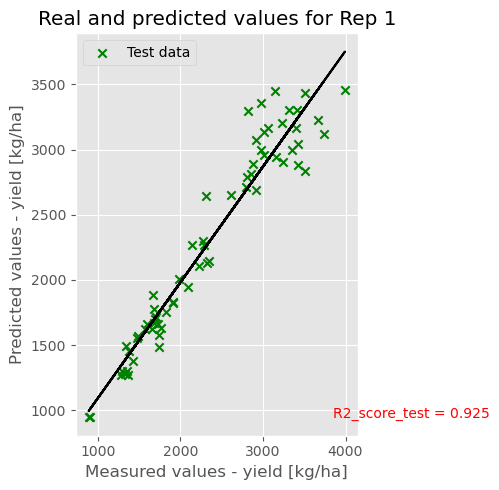


Predictions for Rep 2:
MAE test: 118.772
MSE test: 26169.805
R^2 test: 0.965


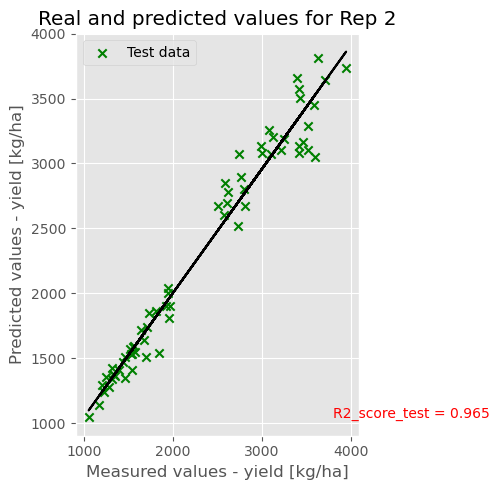


Predictions for Rep 3:
MAE test: 228.262
MSE test: 89120.239
R^2 test: 0.875


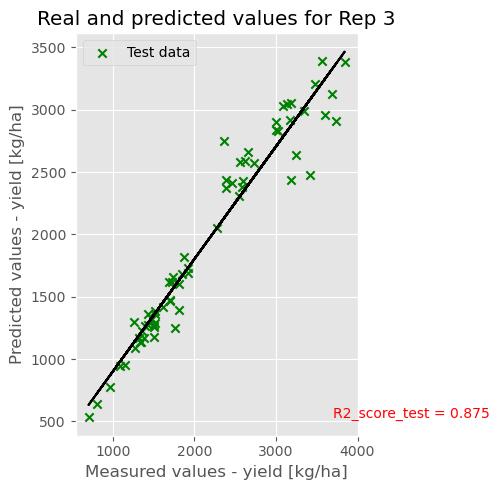

In [14]:
mae_list, mse_list, r2_list = [], [], []

for i in range(1,4):
    print('\nPredictions for Rep {}:'.format(i))
    X_test=X_test_dict['X_test_{}'.format(i)]
    Y_test=Y_test_dict['Y_test_{}'.format(i)]
    Y_pred=reg_dict['reg_{}'.format(i)].predict(X_test)

    mae=mean_absolute_error(Y_test,Y_pred)
    mse=mean_squared_error(Y_test,Y_pred)
    r2=r2_score(Y_test,Y_pred)
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

    print('MAE test: {:.3f}'.format(mae))
    print('MSE test: {:.3f}'.format(mse))
    print('R^2 test: {:.3f}'.format(r2))
    
    plot_regression(Y_test,Y_pred,directory=results_dir, rep=str(i))

In [15]:
print('Average metrics:')
print('MAE test: {:.3f}'.format(np.mean(mae_list)))
print('MSE test: {:.3f}'.format(np.mean(mse_list)))
print('R^2 test: {:.3f}'.format(np.mean(r2_list)))

Average metrics:
MAE test: 167.158
MSE test: 55135.385
R^2 test: 0.922
